# Data Preparation

This section is for processing the data in preparation for phase retrieval


In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import os
import PIL
from tqdm.notebook import tqdm, trange
import time
import os
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.widgets import Button, TextBox
from concurrent.futures import ProcessPoolExecutor

from matplotlib.patches import Rectangle
from IPython.display import display
import ipympl
import ipywidgets 
import hdf5plugin
import importlib

import pyxtools.data_loader.cbd_loader as db
import pyxtools.data_loader.kvectors as ks
import pyxtools.data_loader.utils as ut
import pyxtools.data_loader.plotting as pxp
import pyxtools.data_loader.data_fs as dx

import logging
logging.getLogger('matplotlib').setLevel(logging.WARNING)


ModuleNotFoundError: No module named 'pyxtools'

In [3]:
# refreshes
importlib.reload(ks)
importlib.reload(pxp)
importlib.reload(ut)
importlib.reload(dx)
importlib.reload(db)


NameError: name 'ks' is not defined

### Init

In [4]:
class Exp:
    det_psize = 75 # microns
    energy = 17.5 #keV
    wavelength = ut.energy2wavelength_a(energy)
    det_npixel = ( 4362, 4148)
    crys_distance = 187e3 # mircons
    step_size = 250 # Angstroms
    number_of_steps = 61 # steps
    beam_spot_size = 40 # Angstroms


exp = Exp()

exp.centre_pixel = (1839,2090)

In [5]:
importlib.reload(db)

gold = db.load_data(
    directory = '/asap3/petra3/gpfs/p11/2024/data/11018732/raw/scan_frames',
    scan_num = 267,
    det_psize = exp.det_psize, 
    det_distance = exp.crys_distance,
    centre_pixel = exp.centre_pixel, 
    wavelength = exp.wavelength,
    slow_axis = 0, # 0 for x
    num_jobs=64 # for parallelistaion 
)

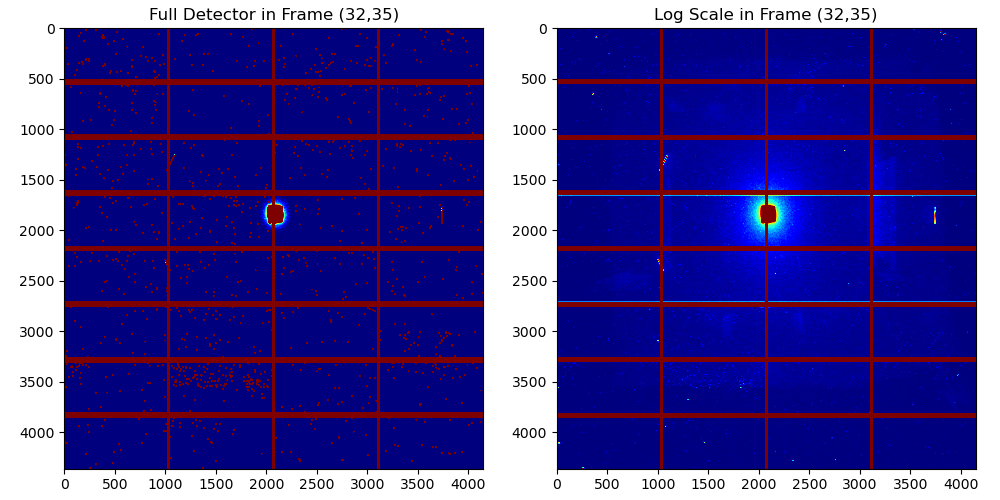

In [6]:
gold.plot_full_detector(32, # row
                        35, # col
                       vmin1 = 1, vmax1=4,
                       vmin2 = 0, vmax2=2)

In [7]:
gold.add_roi(roi_name = "pupil"   , roi = [1750,1950,2001,2181])
gold.add_roi(roi_name = "streak_1", roi = [2275,2425, 970,1075]) # Si Streak 
gold.add_roi(roi_name = "streak_2", roi = [2950,3130, 850,1020]) # Gold Streak 
gold.add_roi(roi_name = "streak_3", roi = [1250,1450, 980,1110]) # 
gold.add_roi(roi_name = "streak_4", roi = [1760,1950,3700,3800])
gold.add_roi(roi_name = "full_det", roi = [   0,  -1,   0,  -1])

Function 'mask_hot_pixels' executed in 0.047788 seconds


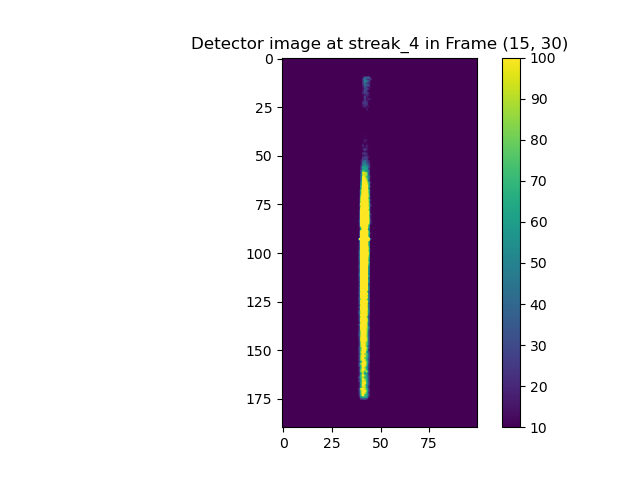

In [8]:
%matplotlib ipympl

gold.plot_detector_roi('streak_4', # Roi to Plot
                       15, # row 
                       30, # col
                       vmin = 1e1, 
                       vmax = 1e2, 
                       mask_hot = True # Mask hot pixels
                      )

### Bright Field

In [9]:
gold.prepare_roi("pupil", # ROI Name
                mask_val = 750, # Threshold of detector value
                pool_det = (5,1,0), # Detector Binning (Bin, Stride, Pad)
                'streak_4' # Normalisation ROI
                )

(1839, 2090)
Function 'stack_4d_data' executed in 6.151577 seconds
Function 'mask_hot_pixels' executed in 0.396477 seconds
Function 'stack_4d_data' executed in 6.277499 seconds
Function 'mask_hot_pixels' executed in 0.211269 seconds
Pooling detector ...
Function 'sum_pool2d_array' executed in 0.967045 seconds
Done.


In [10]:
gold.compute_kins("pupil", # ROI Name
                  est_ttheta = 0 # Predicted Two Theta 
                 )

In [13]:
gold.prepare_coherent_images("pupil", # ROI Name
                            variance_threshold = 10000, 
                            mask_region = (0,3,0,3),
                            ) 

Function 'make_coherent_images' executed in 0.155915 seconds
Function 'filter_images' executed in 0.505664 seconds
Function 'reorder_pixels_from_center' executed in 0.001936 seconds
sorted_indices dtype: int64, shape: (14040,)
kouts shape before indexing: (14040, 3)
Did not order detected objects.


### Dark Field 

In [100]:
gold.prepare_roi("streak_2", 
                mask_val = 1, 
                pool_det = (1,1,0), # Detector Binning (Bin, Stride, Pad)
                normalisation_roi = 'streak_4' # Normalisation ROI
                )

(1839, 2090)
Function 'stack_4d_data' executed in 8.866974 seconds
Function 'mask_hot_pixels' executed in 0.341057 seconds
Pooling detector ...
Function 'sum_pool2d_array' executed in 0.460295 seconds
Done.


In [101]:
ttheta_rad = np.deg2rad(34.329) #Gold (400) reflection
gold.compute_kins("streak_2", est_ttheta = ttheta_rad)

the initial 2theta angle is: 33.65595130201461
         Current function value: 0.037468
         Iterations: 13
         Function evaluations: 283
         Gradient evaluations: 68


In [102]:
gold.refine_kins("streak_2", (0.02,0.009,-0.005))

#### Prepare coherent images

In [108]:
gold.prepare_coherent_images("streak_2", 
                            variance_threshold = 0.4, 
                            bilateral_params =  (.2,.2,2), # sigma_spatial, sigma_range, kernel_size
                            detect_params = (.02, 200, 600), # threshold, min_val, max_val
                            align_cohimgs = True, 
                            order_imgs=True # Order images from centre
                            )

Function 'make_coherent_images' executed in 0.010134 seconds
Function 'filter_images' executed in 0.027788 seconds
Function 'reorder_pixels_from_center' executed in 0.000412 seconds
sorted_indices dtype: int64, shape: (829,)
kouts shape before indexing: (829, 3)
Did not order detected objects.
Function 'bilateral_filter_parallel' executed in 82.316111 seconds
Function 'detect_obj_parallel' executed in 3.167084 seconds
length of the mask is 782
length of detected objects (782, 62, 60)
length of coherent images (782, 62, 60)


### Saving K, Coherent Images

In [132]:
np.save("kin_indices.npy", gold.kin_coords["streak_2"])
np.save("kout_indices.npy", gold.kout_coords["streak_2"])
np.save("coherent_images.npy", gold.coherent_imgs["streak_2"])


# Dark Field Reconstruction


In [123]:
# refresh 
from pyxtools.phase_retrieval import epry_class
from pyxtools.phase_retrieval import utils_pr
importlib.reload(utils_pr)
importlib.reload(epry_class)


<module 'pyxtools.phase_retrieval.epry_class' from '/home/mohahmed/Analysis_P11/pyxtools/phase_retrieval/epry_class.py'>

Text(0.5, 1.0, 'Initialised Object Phase')

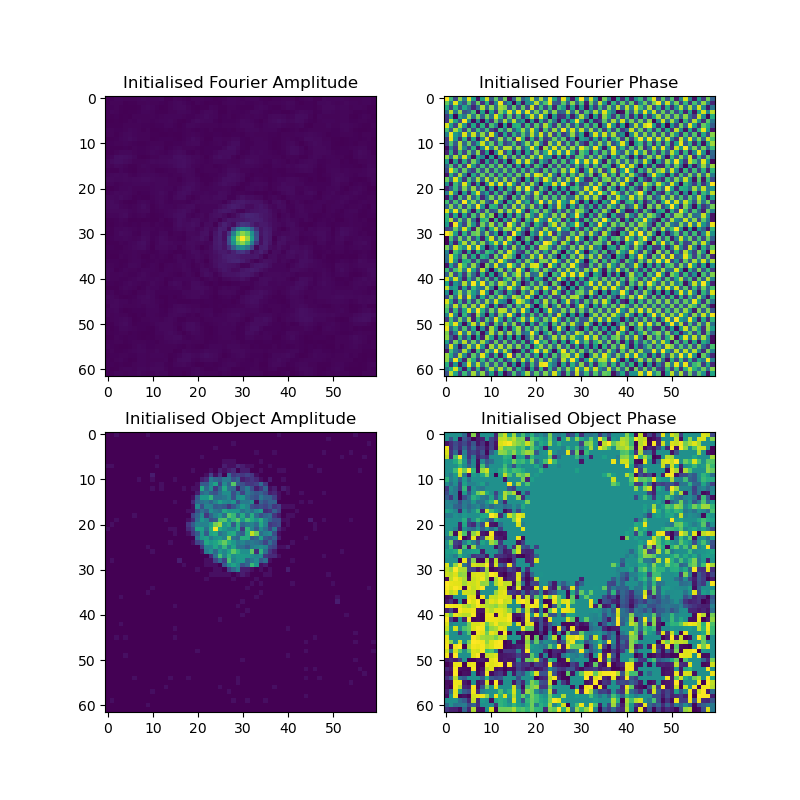

In [124]:
from numpy.fft import fftshift, ifftshift, fft2, ifft2

#  initialisation 
image_ft = fftshift(fft2(coh_images[0]) ) #*np.exp(1j*coh_images[0])))

init_fourier = image_ft # np.abs(image_ft) * np.exp(1j*np.random.normal(loc=0.0, scale=np.pi/2, size=image_ft.shape)) #  #np.exp(1j*np.ones_like(image_ft)) #
init_object = ifft2(ifftshift(init_fourier))

fig, ax = plt.subplots(2,2, figsize=(8,8))
ax[0,0].imshow(np.abs(init_fourier))
ax[0,0].set_title("Initialised Fourier Amplitude")
ax2 = ax[0,1].imshow(np.angle(init_fourier))

ax[0,1].set_title("Initialised Fourier Phase")
ax[1,0].imshow(np.abs(init_object))
ax[1,0].set_title("Initialised Object Amplitude")
ax[1,1].imshow(np.angle(init_object))
ax[1,1].set_title("Initialised Object Phase")



In [125]:
from time import strftime
time_str = strftime("%Y-%m-%d_%H.%M")

epry_df_lr = epry_class.EPRy_lr(coh_images,  # Coherent Images
                                pupil_func = 'phase_aberration_run215.npy', # Pupil 
                                hr_fourier_image = init_fourier, # Initialised Fourier Image
                                kout_vec = gold.kins["streak_2"], # Kin vectors
                                ks_pupil = gold.kins["pupil"], # Pupil Kins
                                lr_psize = exp.step_size, # Step Size 
                                alpha = .2, 
                                beta = .9)

epry_df_lr.prepare(extend = 'double')

Preparing
(-0.49954459628990344, 0.48888635262264457)
(2438, 2242)
Function 'prepare' executed in 0.375396 seconds


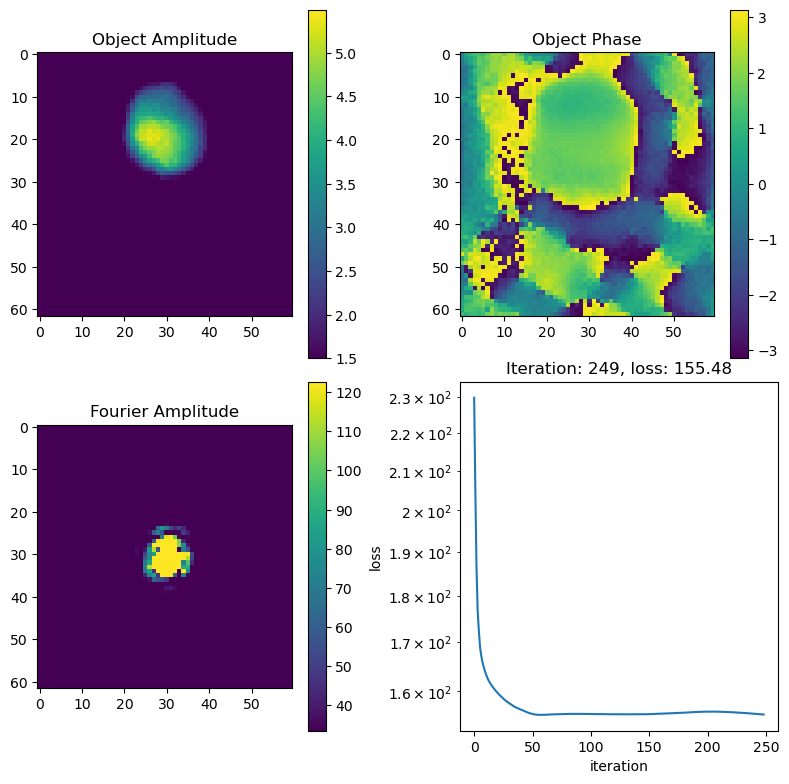

Function 'iterate' executed in 348.212795 seconds


In [126]:
epry_df_lr.iterate(iterations=250, 
                   live_plot=True)

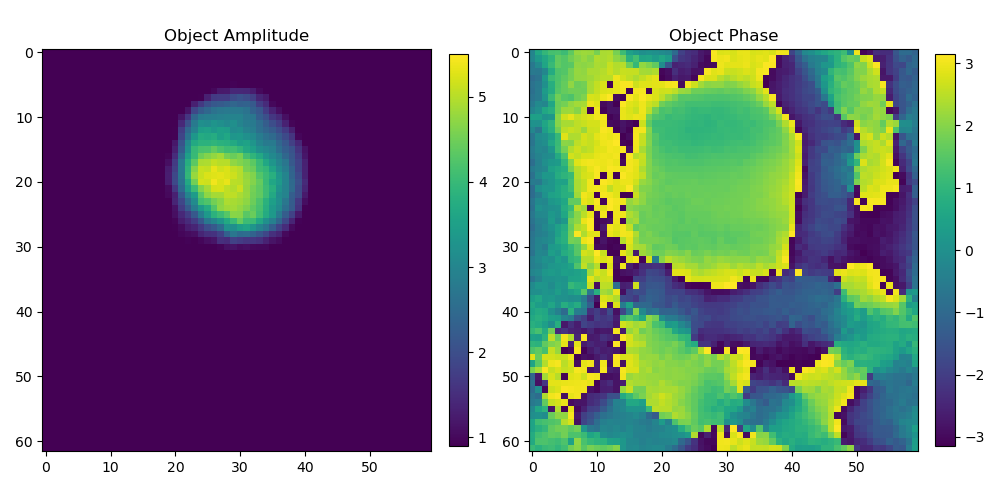

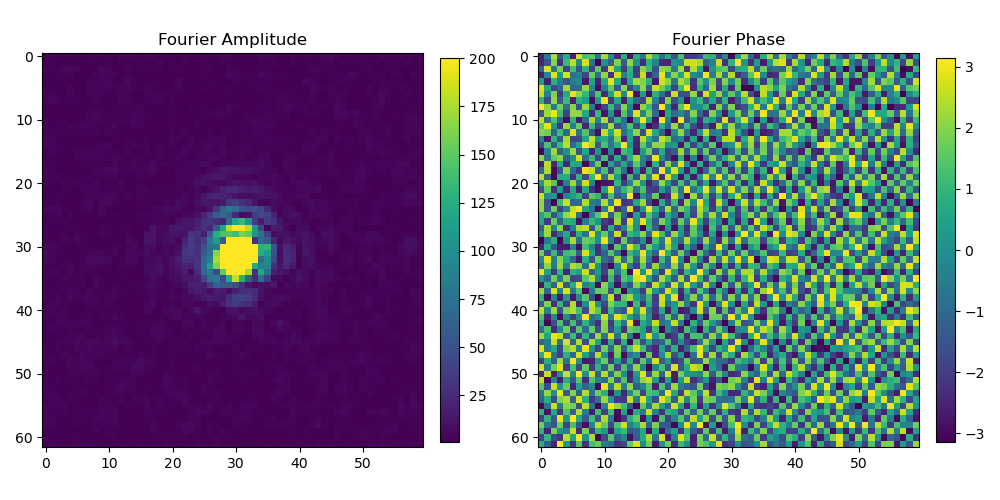

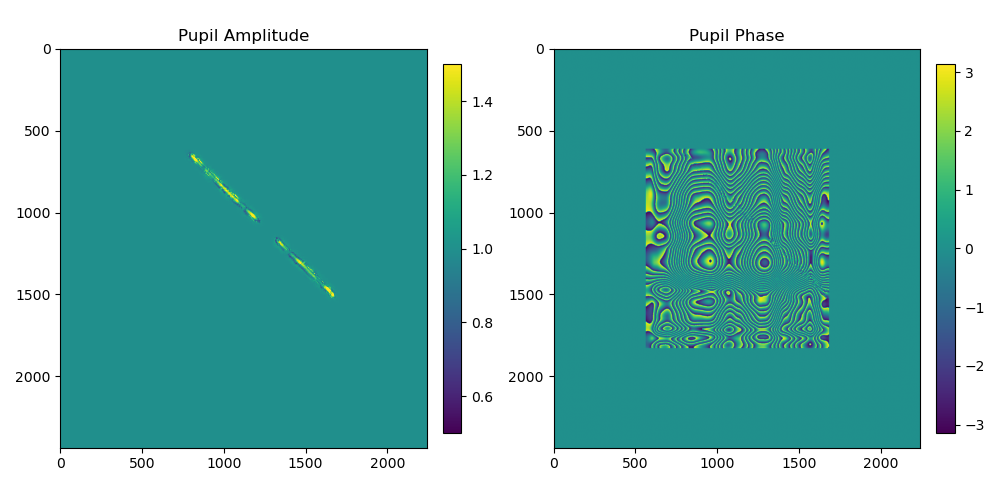

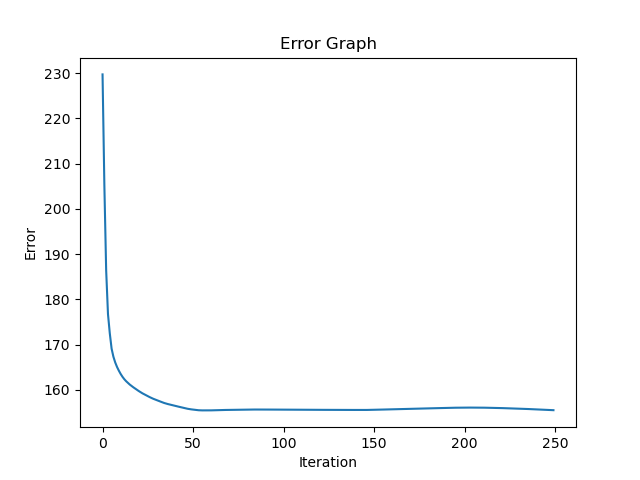

In [128]:
epry_df_lr.plot_rec_obj(vmin1=.9, vmax1=5.5)
epry_df_lr.plot_rec_fourier(vmin1 = 1, vmax1 = 200)
epry_df_lr.plot_pupil_func(vmin2=-np.pi, vmax2=np.pi ) 
epry_df_lr.plot_losses()